## Подготовка данных к тренировке моделей

### Загрузка и очистка данных

In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
df = pd.read_csv("liver.csv")
df.duplicated().where(lambda x: x == True).dropna() ##  Явных дубликатов не найдено
df = df.dropna().reset_index()

# for col in df.columns:
#     print(df[col].unique())

df["Gender"] = df["Gender"].replace("Mal","Male")
df["Gender"] = df["Gender"].replace(["Male","Female"],[0,1])
df["Dataset123"] = df["Dataset123"].replace(["yes","no"],["1","2"])
df["Dataset123"] = df["Dataset123"].replace(["1","2"],["1","0"])
df["Aspartate_Aminotransferase"] = df["Aspartate_Aminotransferase"].replace("3a4","34")
df = df.rename(columns={"Dataset123":"IsSick"})
df = df.astype({
    'Gender':'int64',
    "IsSick":"int64",
    "Alkaline_Phosphotase":"int64",
    "Aspartate_Aminotransferase":"int64"})

### Проверка данных перед обучением моделей

#### Проверим отношение обектов двух классов

In [174]:
isSick = list(df["IsSick"])
Sick = len(list(filter(lambda x: x == 1,isSick)))
ratio = Sick/len(isSick)
ratio




0.7155172413793104

Больных людей в нашей выборке 71%, а больных соответсвенно - 29%. Это отношение не соовтествует условию баланса классов, значит точность обучения модели мы будем считать методами отличными от Accuracy 

#### Проверка зависымых друг от друга показателей

<AxesSubplot: >

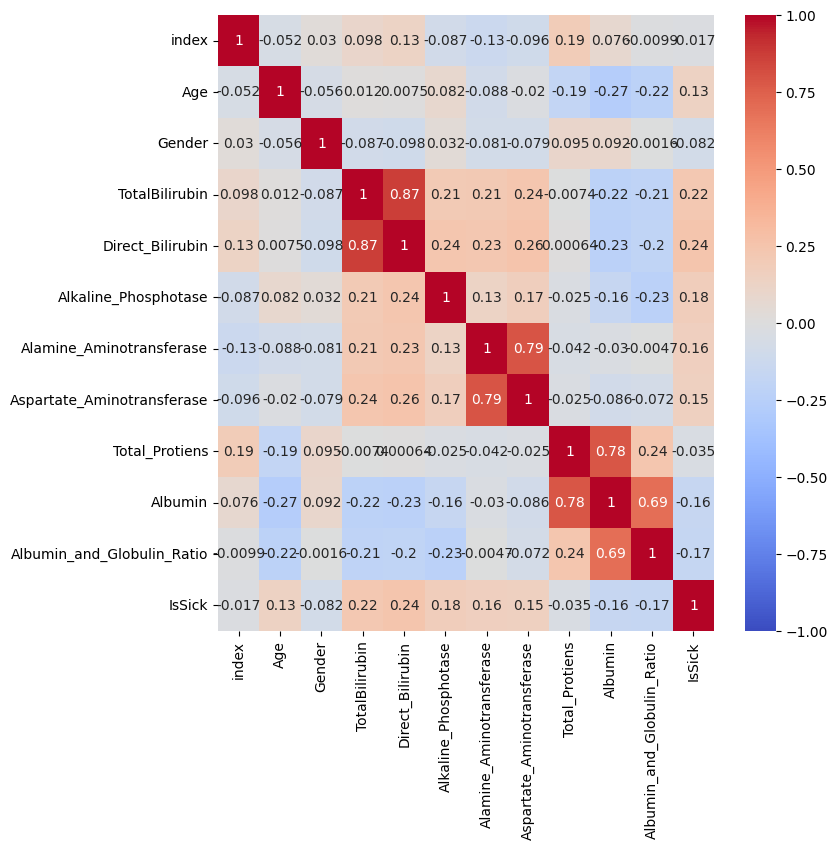

In [175]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))  
sns.heatmap(df.corr(),vmin=-1,vmax=1,annot=True,cmap="coolwarm",ax=ax)

#### Исправление данных для устранения зависимых показателей

Вы видим, что общий и прямой билирубин  сильно зависят друг от друга, а также сильно зависят друг от друга и АСТ/АЛТ, а так же Альбумин и общий уровень белков.
Я немного видоизменю эти данные, и вместо пары зависимых между собой значений укажу одно значение, которое будет средним среди этих двух

In [176]:
pairs = [["Alamine_Aminotransferase","Aspartate_Aminotransferase"],["Albumin","Total_Protiens"],["Direct_Bilirubin","TotalBilirubin"]]
AvgNames = ["ALT_AST","ALBUMINPROTEIN","BILIRUBIN"]
for i in range(len(pairs)):
    avg = [float(df[pairs[i][0]][j]+df[pairs[i][1]][j])/2 for j in range(len(df[pairs[i][0]]))]
    df[AvgNames[i]] = avg

for i in pairs:
    for j in i:
        df = df.drop([j],axis=1)

###  Подготовка выборок для обучения и проверки

In [177]:
from sklearn.model_selection import train_test_split
target = df["IsSick"]
data = df.drop(["IsSick"],axis=1)
dataTrain, dataTest, targetTrain,targetTest = train_test_split(data,target,test_size=0.5,random_state=0)

## Создание и обучение моделей

#### Обучим три модели данных
* Логичтическая регрессия
* К-Ближайших соседей
* Случайный лес

#### Для начала импортируем все необходимые библиотеки и нормализируем данные

In [178]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler

#### Теперь создадим модели данных, и тут же обучим их, а также посчитаем метрики

In [179]:
scaler = StandardScaler()
scaler.fit(data)
dataTrain = scaler.transform(dataTrain)
dataTest  = scaler.transform(dataTest)
#Обучение моделей
models={
"KNeighbors":KNeighborsClassifier(n_neighbors=5),
"RandomForest":RandomForestClassifier(n_estimators=100),
"LogisticRegression": LogisticRegression(max_iter=5000)}
predictions = {}
metrics = {}
for key in models:
    models[key].fit(dataTrain, targetTrain)
    predictions[key] = models[key].predict(dataTest)
    metrics[key] = {
        "ACC":accuracy_score(targetTest,predictions[key]),
        "PREC":precision_score(targetTest,predictions[key]),
        "RECL":recall_score(targetTest,predictions[key]),
        "BLAC":balanced_accuracy_score(targetTest,predictions[key]),
        "F1":f1_score(targetTest,predictions[key])
    }

## Метрики

#### Выведем результаты обучений. Помимо стандартных метрик я добавил среднее значение среди всех метрик

In [180]:
for key in models:
    print(key,end=":\n")
    for metric in metrics[key]:
        print("\t",metric,":",str(metrics[key][metric]))
    print("\tAVG:", sum(metrics[key].values())/5)

KNeighbors:
	 ACC : 0.6586206896551724
	 PREC : 0.7166666666666667
	 RECL : 0.8472906403940886
	 BLAC : 0.5328407224958949
	 F1 : 0.7765237020316027
	AVG: 0.7063884842486851
RandomForest:
	 ACC : 0.7068965517241379
	 PREC : 0.7379032258064516
	 RECL : 0.9014778325123153
	 BLAC : 0.577175697865353
	 F1 : 0.811529933481153
	AVG: 0.7469966482778821
LogisticRegression:
	 ACC : 0.6896551724137931
	 PREC : 0.7132075471698113
	 RECL : 0.9310344827586207
	 BLAC : 0.5287356321839081
	 F1 : 0.8076923076923077
	AVG: 0.7340650284436882


Основываясь на предоставленных данных, мы можем сказать что все наши модели хорошо показывают себя на метрике Recall (>0.8), а в самой эффективной модели Logistic regression этот показатель даже выше 0.9

#### Построим матрицу неточностей для всех натренированных моделей

In [181]:
from sklearn.metrics import confusion_matrix
cms = {}
for model in models:
    cm = confusion_matrix(targetTest,predictions[model])
    tn,fp,fn,tp = cm.ravel()
    cms[model] ={
        "TP":tp,
        "FP":fp,
        "TN":tn,
        "fn":fn
    }
cms

{'KNeighbors': {'TP': 172, 'FP': 68, 'TN': 19, 'fn': 31},
 'RandomForest': {'TP': 183, 'FP': 65, 'TN': 22, 'fn': 20},
 'LogisticRegression': {'TP': 189, 'FP': 76, 'TN': 11, 'fn': 14}}

Как видно из данной матрицы наши модель оказались "оптимистичными", и в них достаточно много ложно-положительных результатов, однако можно заметить, что у метода к-сосеседей также и достаточно большое количество ложно-отрицатильных результатов

#### Произведем расчет значения ROC кривой для всех моделей

In [182]:
from matplotlib import pyplot as plt
rocs = {}
for model in models:
    prob = models[model].predict_proba(dataTest)
    prob = prob[:,1]
    model_auc = roc_auc_score(targetTest,prob)
    fpr, tpr, threshold = roc_curve(targetTest,prob)
    roc_auc = auc(fpr,tpr)
    rocs[model]={
        "TPR":tpr,
        "FPR":fpr,
        "AUC":roc_auc
    } 
for roc in rocs:
    print(roc," ROC AUC:", str(rocs[roc]["AUC"]))

KNeighbors  ROC AUC: 0.6223033803295397
RandomForest  ROC AUC: 0.743757431629013
LogisticRegression  ROC AUC: 0.7099824472000453


#### График ROC кривых

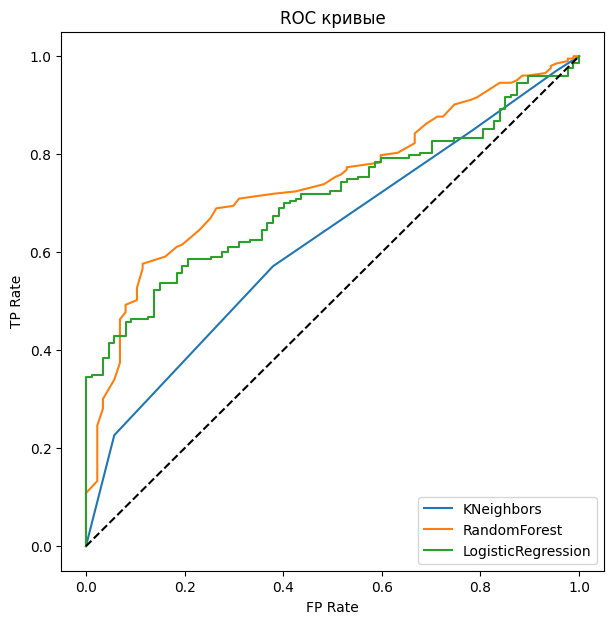

In [183]:
plt.figure(figsize=(7,7))
for model in models:
    plt.plot(rocs[model]["FPR"],rocs[model]["TPR"],label=model % rocs[model]["AUC"])
plt.plot([0,1],[0,1],color="black",linestyle="--")
plt.xlim=([0.0,1.0])
plt.ylim=([0.0,1.01])
plt.xlabel("FP Rate")
plt.ylabel("TP Rate")
plt.title("ROC кривые")
plt.legend(loc="lower right")
plt.show()

## Вывод:
Во время выполнения данной лабораторной работы были получены практические навыки использования алгоритмов и методов классификации, таких как метод ближайших соседей, логическая регрессия и случайное дерево. После оценки классификации по различным метрикам, построения матрицы неточности и визуализации графика ROC кривых, можно сделать вывод, что несмотря на некоторые недостатки, наилучший результат был получен методом логисчитеской регрессии, так как в среднем результаты этого метода лучше, чем у остальных моделей.